# movie_total 등 저장된 파일 가져오기

In [2]:
import numpy as np
import pandas as pd

In [107]:
movie_total = pd.read_csv("movie_total_2-7.csv")
movie_actor = pd.read_csv("movie_actor.csv")

In [3]:
movie_total.actorList[0]

"['최민식', '류승룡', '조진웅', '김명곤', '진구', '이정현', '권율', '노민우', '김태훈', '이승준', '오타니 료헤이', '박보검', '서성광', '김원해', '이해영', '장준녕', '김길동', '김강일', '강태영', '한상대', '박노식', '최덕문', '조복래', '문영동', '이주실']"

In [4]:
type(movie_total.actorList[0])

str

actorList 열이 str이 되어버렸으므로 다시 리스트로 바꾸어주자

## actorList(str) to List

In [6]:
def strTolist(str):
    str = str[2:-2]
    list = str.split("', '")
    return list

In [6]:
actorList = movie_total.actorList.apply(strTolist)

In [7]:
movie_total['actorList'] = pd.Series(actorList)

# movie_actor 만들기

movie_actor은 출연영화와 배우간의 쌍으로 이루어진 Table이다. 즉, movie_total과 actor_total의 조합으로 이루어진 dataset이라고 생각하면 된다. (relation)  
이 때, movieNm, movieCd, actorNm 등을 column으로 넣어주고, 다른 열의 경우엔 movieCd를 통해 가져온다.

In [9]:
movieNm = movie_total.movieNm.tolist()
movieCd = movie_total.movieCd.tolist()
actorList = movie_total.actorList.tolist()

In [10]:
#R은 relation의 약자
RmovieNm = []
RmovieCd = []
RactorNm = []

In [11]:
for i in movie_total.index.tolist():
    for j in actorList[i]:
        RmovieNm.append(movieNm[i])
        RmovieCd.append(movieCd[i])
        RactorNm.append(j)

In [12]:
movie_actor = pd.DataFrame({'movieNm':RmovieNm, 'movieCd':RmovieCd, 'actorNm':RactorNm})

In [13]:
#영화배우 이름이 없는 행은 지워준다.
movie_actor = movie_actor[movie_actor.actorNm!=""].reset_index(drop=True)

# Feature 추가하기

## 배우코드(actorCd) 추가하기

동명이인을 처리해주기 위해서 actorCd를 넣어준다.

배우이름과 필모리스트를 통해 조회  
영화인명단이 나옴  

한국영화의 경우, 배우.감독 겸직이 거의 없으므로  
그 중 배우인 사람들만으로 배우리스트를 만듬.
배우리스트에 cnt==0이면 그 열 삭제(제작진이 들어간 것)

외국영화의 경우, 배우.감독 겸직이 존재.  
또한 배우가 배우로 들어가지 않은 경우도 존재.
따라서 외국영화의 경우, totcnt>0이면 이름이 동일하면 넣어주기

In [3]:
import urllib

In [15]:
#한국 영화와 외국영화의 차이가 있기 때문에 국적을 넣어준다.
tempMerge = movie_total[['movieCd', 'repNationNm']]
movie_actor = pd.merge(movie_actor, tempMerge, on='movieCd', how='left')

In [17]:
#영화진흥원 키를 사용하기 위한 kobisKey
kobisKey = ['036ec0b9bd53529ea2dc74ea008e9d91', 'e4cca38919fb306d822c32d7d14d5a52', '20bfdc740feb247ca6eca9a04f5f9e86'
            ,'70e6e54392ec981956fb99e7e2f57e16', '82a0463123d6111d50a52206ecc82d69', '44e32445d382c479dfbfe7164e586109'
            ,'e6579370845ffc3095aeb29a301f2f37', 'ef1d12d352ac16d8509140f88ffd9902', '34ceb556cdfbeb005650d6cbaa13d5fe']

In [18]:
#for문을 돌리는 데 필요한 antorNm, movieNm, repNationNm
actorNm = movie_actor.actorNm.tolist()
movieNm = movie_actor.movieNm.tolist()

#만들어질 column : actorCd
actorCd = []

In [19]:
##error 확인용

#error확인시 필요한 for문을 위해 넣는 list
repNationNm = movie_actor.repNationNm.tolist()
movieCd = movie_actor.movieCd.tolist()

#errorList를 위한 columns
Eindex = []
EmovieNm = []
EmovieCd = []
EactorNm = []
ErepRoleNm = []

In [36]:
for i in movie_actor.index.tolist()[5502:]:
    #영화인 데이터 조회
    tempActNm = actorNm[i]
    tempMvNm = movieNm[i]
    
    tempActNm = urllib.parse.quote(tempActNm, safe='')
    tempMvNm = urllib.parse.quote(tempMvNm, safe='')
    
    movieURL = "http://www.kobis.or.kr/kobisopenapi/webservice/rest/people/searchPeopleList.json?key={0}&peopleNm={1}&filmoNames={2}&itemPerPage=100".format(kobisKey[5], tempActNm, tempMvNm)
    moviePage = urllib.request.urlopen(movieURL)
    movieData = json.loads(moviePage.read())
    
    #배우리스트 뽑아오기
    tempActList = []
    for j in movieData['peopleListResult']['peopleList']:
        #배우이고, 이름이 동일하고, 출연작이 동일하면 tempActList에 추가
        if ((j['repRoleNm']=='배우')&(j['peopleNm']==actorNm[i])&(j['filmoNames'].split("|").count(movieNm[i])>0)):
            tempActList.append(j)
    
    #배우코드 넣기
    if(len(tempActList)==1): #actorList가 1명이면 바로 대입
        tempActCd = tempActList[0]['peopleCd']
        
    elif(len(tempActList)>1):
        tempActCd = "00000001" #한 작품에 같은 이름의 배우가 출연한 동명이인
    
    elif(len(tempActList)==0):
        if(repNationNm[i]!="한국"):
            if (movieData['peopleListResult']['totCnt']==1): #외국영화의 경우 찾는 사람이 1명밖에 안나오면 넣는다.
                tempActCd = movieData['peopleListResult']['peopleList'][0]['peopleCd']
                
            elif (movieData['peopleListResult']['totCnt']==0): tempActCd='00000002' #외국영화의 경우 찾는사람이 안나오면 넣는다.
            else : tempActCd='00000003' #기타
                
        else: #한국 영화의 경우 찾는 배우가 안나오면 넣는다.
            tempActCd = '00000000'
            
            for j in movieData['peopleListResult']['peopleList']:
                Eindex.append(i)
                EmovieNm.append(movieNm[i])
                EmovieCd.append(movieCd[i])
                EactorNm.append(j['peopleNm'])
                ErepRoleNm.append(j['repRoleNm'])
                
    else:
        tempActCd = '00000004' #그 외 기타의 경우
                
    #배우코드 actorCd에 넣어주기
    actorCd.append(tempActCd)
    
    if(i%100==0):
        print(i)

5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000


In [40]:
#actorCd 넣어주기, errorList 만들기
movie_actor['actorCd'] = pd.Series(actorCd)
errorList = pd.DataFrame({'index':Eindex, 'movieNm': EmovieNm, 'movieCd':EmovieCd,'actorNm':EactorNm, 'repRoleNm':ErepRoleNm})

In [104]:
movie_actor.to_csv("movie_actor_before_dropError.csv", index=False, encoding='utf-8')

In [128]:
#actorCd=='00000000' 처리 : 삭제
movie_actor = movie_actor[movie_actor.actorCd!='00000000']
movie_actor = movie_actor.reset_index(drop=True)

In [131]:
#같은 작품에 동일한 배우가 나왔을 것이라고 생각되는 명단들
movie_actor[movie_actor.actorCd=='00000001']

,movieNm,movieCd,actorNm,repNationNm,actorCd
2324,식객,20070435,정진,한국,00000001
4984,탐정 홍길동: 사라진 마을,20142406,김하나,한국,00000001
9145,달콤한 거짓말,20080750,채민서,한국,00000001
9654,미스터 주부퀴즈왕,20050237,이주현,한국,00000001


In [130]:
#actorCd=='00000001' 처리 : 입력 후 삭제
#이름과 필모, 맡은 역을 잘 보고 넣어주어야한다.
movie_actor.actorCd[424]='10029093'
movie_actor.actorCd[842]='10057329'
movie_actor.actorCd[1765]='20125821'
movie_actor.actorCd[2315]='20133634'
movie_actor.actorCd[2316]='10062270'
movie_actor.actorCd[2855]='10061581'
movie_actor.actorCd[2862]='20110690'
movie_actor.actorCd[3318]='10062279'
movie_actor.actorCd[4981]='20274790'
movie_actor.actorCd[5373]='20133526'
movie_actor.actorCd[5374]='10029413'
movie_actor.actorCd[6496]='20110693'
movie_actor.actorCd[8239]='10058190'
movie_actor.actorCd[8243]='20115001'
movie_actor.actorCd[8366]='20153088'
movie_actor.actorCd[9144]='10071672'
movie_actor.actorCd[9650]='20066512'
movie_actor.actorCd[11975]='20127460'
movie_actor.actorCd[13185]='20145269'

In [132]:
#삭제
movie_actor = movie_actor[movie_actor.actorCd!='00000001']
movie_actor = movie_actor.reset_index(drop=True)

In [134]:
#동일한 것들 전부 지워주기(kobis에서 확인하고)
movie_actor[movie_actor.duplicated(keep=False)]
movie_actor = movie_actor.drop_duplicates().reset_index(drop=True)

In [ ]:
errorList.to_csv('errorList_actor.csv', index = False, encoding='utf-8')

### 영어이름 추가하기

In [189]:
actorCd = movie_actor.actorCd.tolist()
#actorEnNm = []

for i in movie_actor.index.tolist()[11999:]:
    movieURL = "http://www.kobis.or.kr/kobisopenapi/webservice/rest/people/searchPeopleInfo.json?key={0}&peopleCd={1}".format(kobisKey[1], actorCd[i])
    moviePage = urllib.request.urlopen(movieURL)
    movieData = json.loads(moviePage.read())
    tempEnNm = movieData['peopleInfoResult']['peopleInfo']['peopleNmEn']
    actorEnNm.append(tempEnNm)
    
    if(i%100==0):
        print(i)

12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600


In [191]:
len(actorEnNm)

13695

In [192]:
len(movie_actor)

13695

In [193]:
movie_actor['actorEnNm'] = pd.Series(actorEnNm)

In [195]:
movie_actor.to_csv("movie_actor.csv", index=False, encoding='utf-8')

## 주조연 정보(actorRole) 추가하기

한국 배우의 경우에는 한글이름으로 주조연 정보를 추가해주고, 외국 배우의 경우에는 영어로 주조연 정보를 추가해준다.

### movie_actorRole 만들기

In [4]:
from bs4 import BeautifulSoup

In [16]:
#영화별 naverCd로 가져와야 하므로 naverCd dataframe을 만들어준다.
naverCd = movie_total[['movieNm', 'movieCd' ,'naverCd']]

In [47]:
actorNm = []
naverEnNm = []
actorRole = []
movieCd = []

for i in naverCd.index.tolist(): #전체 영화 2182개의 naverCd에서
    #네이버코드대로 영화를 가져오고
    naverURL = "https://movie.naver.com/movie/bi/mi/detail.nhn?code={0}".format(naverCd.naverCd[i])
    naverPage = urllib.request.urlopen(naverURL)
    html = naverPage.read().decode('utf-8')
    soup = BeautifulSoup(html, "html5lib")
    lst_people = soup.find('ul', class_='lst_people')
    
    #lst_people을 가져오는데 성공하면 try 실패하면, except(영화이름이랑 코드를 가져와라)
    try:
        lis = lst_people.find_all('div', class_='p_info')
    except:
        print(naverCd.movieNm[i], naverCd.naverCd[i])
        continue

    for li in lis:
        p_name = li.find('a').get_text()
        p_part = li.find('div', class_="part").find('p').find('em', class_="p_part").get_text()
        e_name = li.find("em").get_text()
        #code_st = re.search('code=[0-9]+',URL).group()
        actorNm.append(p_name)
        naverEnNm.append(e_name)
        actorRole.append(p_part)
        movieCd.append(naverCd.movieCd[i])
        
    if(i%100==0):
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
최강전사 미니특공대: 영웅의 탄생 145376
다이노소어 어드벤처 : 백악기 공룡대백과 148608
2100


In [48]:
naverEnNm

['',
 '',
 '',
 '',
 '에이바',
 '',
 '권세인',
 '',
 '',
 'Ryohei Otani',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Ha Jung-woo',
 '',
 '',
 'Kim Hyang-Gi',
 '',
 'Don Lee',
 '',
 '',
 'D.O.',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '박상연',
 '',
 '',
 '',
 '',
 '',
 'CHOE STELLA KIM',
 '',
 '',
 'Sam Worthington',
 'Zoe Saldana',
 'Sigourney Weaver',
 'Stephen Lang',
 'Michelle Rodriguez',
 'Giovanni Ribisi',
 'Joel Moore',
 'CCH Pounder',
 'Wes Studi',
 'Laz Alonso',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Song Kang-ho',
 '변인철',
 '',
 '',
 'Ko Asung',
 '',
 '',
 '',
 'Yoon Je-Moon',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Simon Yam',
 '',
 '',
 '',
 'Angelica Lee',
 'Derek Tsang',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Ha Jung-woo',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',


In [49]:
movie_actorRole = pd.DataFrame({'movieCd':movieCd, 'actorNm':actorNm, 'actorEnNm':naverEnNm,'actorRole':actorRole})

In [51]:
movie_actorRole[movie_actorRole.actorEnNm!=""]

,movieCd,actorNm,actorEnNm,actorRole
4,20129370,이정현,에이바,조연
6,20129370,권율,권세인,조연
9,20129370,오타니 료헤이,Ryohei Otani,조연
33,20150976,하정우,Ha Jung-woo,주연
36,20150976,김향기,Kim Hyang-Gi,주연
38,20150976,마동석,Don Lee,주연
41,20150976,디오,D.O.,조연
58,20137048,태인호,박상연,조연
64,20137048,최 스텔라 김,CHOE STELLA KIM,조연
67,20090834,샘 워싱턴,Sam Worthington,주연


In [56]:
#중복 확인
movie_actorRole[movie_actorRole.duplicated(keep=False)]

#어차피 중복이 된다면 actorRole을 병합해줄 때 같은 값이 되므로 중복을 제거해준다.
movie_actorRole = movie_actorRole.drop_duplicates().reset_index(drop=True)

,movieCd,actorNm,actorEnNm,actorRole


In [71]:
#한 작품에 동명이인 확인
movie_actorRole[movie_actorRole.duplicated(subset = ['movieCd', 'actorNm'] ,keep=False)]

,movieCd,actorNm,actorEnNm,actorRole
4805,20050232,정경호,,주연
4811,20050232,정경호,,조연
4898,20156082,바비 모니한,Bobby Moynihan,주연
4905,20156082,바비 모니한,Bobby Moynihan,조연
7676,20126667,데니스 리어리,Denis Leary,주연
7686,20126667,데니스 리어리,Denis Leary,조연
25539,20113911,엘리자베스 데일리,Elizabeth Daily,주연
25568,20113911,엘리자베스 데일리,Elizabeth Daily,조연
29672,20090916,양가휘,,주연
29680,20090916,양가휘,,조연


In [72]:
movie_actorRole = movie_actorRole.drop(4905)
movie_actorRole = movie_actorRole.drop(7686)
movie_actorRole = movie_actorRole.drop(25568)
movie_actorRole = movie_actorRole.drop(29680)
movie_actorRole = movie_actorRole.reset_index(drop=True)

In [73]:
#movie_actorRole.to_csv("movie_actorRole_utf-8.csv", index=False, encoding='utf-8')
movie_actorRole.to_csv("movie_actorRole.csv", index=False, encoding='cp949')

### movie_actor에 actorRole column 추가하기

movie_actor 중 한글이름으로 주조연정보가 매칭이 되면 그걸 사용하고 그렇지 않으면 영어이름으로 주조연 정보를 매칭하여 사용한다.

In [74]:
movie_actorRole

,movieCd,actorNm,actorEnNm,actorRole
0,20129370,최민식,,주연
1,20129370,류승룡,,주연
2,20129370,조진웅,,주연
3,20129370,진구,,조연
4,20129370,이정현,에이바,조연
5,20129370,김명곤,,조연
6,20129370,권율,권세인,조연
7,20129370,노민우,,조연
8,20129370,김태훈,,조연
9,20129370,오타니 료헤이,Ryohei Otani,조연


In [101]:
movie_actorRole1 = movie_actorRole[['movieCd', 'actorNm', 'actorRole']]
movie_actorRole2 = movie_actorRole[['movieCd', 'actorEnNm', 'actorRole']]

In [102]:
#movie_actor와 movie_actorRole을 movieCd와 actorNm을 통해서 병합해준다.
temp = pd.merge(movie_actor, movie_actorRole1, on=['movieCd', 'actorNm'], how='left')

In [103]:
temp[temp.duplicated(subset=['movieCd', 'actorCd'], keep=False)]

,movieNm,movieCd,actorNm,repNationNm,actorCd,actorEnNm,actorRole
2846,내 생애 가장 아름다운 일주일,20050232,정경호,한국,10061581,JUNG Kyung-ho,주연
2847,내 생애 가장 아름다운 일주일,20050232,정경호,한국,10061581,JUNG Kyung-ho,조연
2854,내 생애 가장 아름다운 일주일,20050232,정경호,한국,20110690,JUNG Kyung-ho,주연
2855,내 생애 가장 아름다운 일주일,20050232,정경호,한국,20110690,JUNG Kyung-ho,조연


In [104]:
temp = temp.drop(2847)
temp = temp.drop(2854)

In [105]:
temp_KorNm = temp[temp.actorRole.notna()]
temp_KorNm

,movieNm,movieCd,actorNm,repNationNm,actorCd,actorEnNm,actorRole
0,명량,20129370,최민식,한국,10072251,CHOI Min-shik,주연
1,명량,20129370,류승룡,한국,10019065,RYU Seung-ryong,주연
2,명량,20129370,조진웅,한국,10067353,CHO Jin-woong,주연
3,명량,20129370,김명곤,한국,10004052,KIM Myung-kon,조연
4,명량,20129370,진구,한국,10070417,JIN Goo,조연
5,명량,20129370,이정현,한국,10057329,LEE Jung-hyun,조연
6,명량,20129370,권율,한국,20175963,KWON Yul,조연
7,명량,20129370,노민우,한국,20236729,NO Min-woo,조연
8,명량,20129370,김태훈,한국,10006155,KIM Tae-hun,조연
9,명량,20129370,이승준,한국,10056268,LEE Seung-jun,조연


In [123]:
temp_EnNm = temp[temp.actorRole.isna()]
del temp_EnNm['actorRole']
temp_EnNm

,movieNm,movieCd,actorNm,repNationNm,actorCd,actorEnNm
12,명량,20129370,서성광,한국,20197663,SEO Seong-kwang
19,명량,20129370,한상대,한국,10087498,HAN Sang-dae
31,신과함께-죄와 벌,20150976,도경수,한국,20209526,DOH Kyung-soo
37,신과함께-죄와 벌,20150976,이정재,한국,10057315,LEE Jung-jae
38,신과함께-죄와 벌,20150976,김해숙,한국,10006221,KIM Hae-sook
39,신과함께-죄와 벌,20150976,이경영,한국,10054755,LEE Gyoung-young
40,신과함께-죄와 벌,20150976,김하늘,한국,10006171,KIM Ha-neul
41,신과함께-죄와 벌,20150976,김태준,한국,20148715,KIM Tae-joon
44,신과함께-죄와 벌,20150976,김기태,한국,20196246,KIM Ki-tae
45,신과함께-죄와 벌,20150976,성유빈,한국,20202246,SUNG Yu-bin


In [124]:
temp_EnNm = pd.merge(temp_EnNm, movie_actorRole2, on=['movieCd', 'actorEnNm'], copy=False, how='left')

In [126]:
temp_EnNm[temp_EnNm.duplicated(subset=['movieCd', 'actorNm'], keep=False)]

,movieNm,movieCd,actorNm,repNationNm,actorCd,actorEnNm,actorRole


In [125]:
temp_EnNm = temp_EnNm[temp_EnNm.actorRole.notnull()]
temp_EnNm

,movieNm,movieCd,actorNm,repNationNm,actorCd,actorEnNm,actorRole
45,도둑들,20124034,이심결,한국,10056431,Angelica Lee,주연
121,어벤져스: 인피니티 워,20177478,기네스 팰트로우,미국,10003221,Gwyneth Paltrow,조연
122,어벤져스: 인피니티 워,20177478,베니치오 델 토로,미국,10030723,Benicio Del Toro,조연
123,어벤져스: 인피니티 워,20177478,다네이 거라이라,미국,20123923,Danai Gurira,조연
124,어벤져스: 인피니티 워,20177478,베네딕트 왕,미국,10030718,Benedict Wong,조연
128,인터스텔라,20149120,매튜 매커너히,미국,20113063,Matthew McConaughey,주연
142,아이언맨 3,20121621,기네스 팰트로우,미국,10003221,Gwyneth Paltrow,주연
184,트랜스포머 3,20110659,로지 헌팅턴-휘틀리,미국,20113116,Rosie Huntington-Whiteley,주연
222,스파이더맨: 홈 커밍,20167303,로건 마샬-그린,미국,10015754,Logan Marshall-Green,조연
336,쥬라기 월드: 폴른 킹덤,20179086,제프 골드블럼,미국,10064554,Jeff Goldblum,조연


In [128]:
movie_actor_Role = pd.concat([temp_KorNm, temp_EnNm], ignore_index=True)

In [134]:
movie_actor_Role[movie_actor_Role.duplicated(subset=['movieCd', 'actorNm'], keep=False)]

,movieNm,movieCd,actorNm,repNationNm,actorCd,actorEnNm,actorRole
1567,식객,20070435,정진,한국,20133634,JUNG Jin,조연
1568,식객,20070435,정진,한국,10062270,JUNG Jin,조연
1962,내 생애 가장 아름다운 일주일,20050232,정경호,한국,10061581,JUNG Kyung-ho,주연
1967,내 생애 가장 아름다운 일주일,20050232,정경호,한국,20110690,JUNG Kyung-ho,조연
3645,황진이,20070128,박철호,한국,20133526,PARK Chul-ho,조연
3646,황진이,20070128,박철호,한국,10029413,PARK Cheol-ho,조연
5555,애정결핍이 두 남자에게 미치는 영향,20060283,이혜영,한국,10058190,LEE Hye-young,주연
5558,애정결핍이 두 남자에게 미치는 영향,20060283,이혜영,한국,20115001,LEE Hye-young,조연


In [133]:
movie_actor_Role.actorRole[5558] = '조연'

In [135]:
movie_actor_Role.to_csv('movie_actorCd_Role.csv', index=False, encoding='utf-8')

## movie_actor에 관객수, 매출등의 정보 추가하기

In [7]:
movie_actor_Role = pd.read_csv('movie_actorCd_Role.csv', converters={'actorCd':str, 'movieCd':str})
movie_actor_Role

,movieNm,movieCd,actorNm,repNationNm,actorCd,actorEnNm,actorRole
0,명량,20129370,최민식,한국,10072251,CHOI Min-shik,주연
1,명량,20129370,류승룡,한국,10019065,RYU Seung-ryong,주연
2,명량,20129370,조진웅,한국,10067353,CHO Jin-woong,주연
3,명량,20129370,김명곤,한국,10004052,KIM Myung-kon,조연
4,명량,20129370,진구,한국,10070417,JIN Goo,조연
5,명량,20129370,이정현,한국,10057329,LEE Jung-hyun,조연
6,명량,20129370,권율,한국,20175963,KWON Yul,조연
7,명량,20129370,노민우,한국,20236729,NO Min-woo,조연
8,명량,20129370,김태훈,한국,10006155,KIM Tae-hun,조연
9,명량,20129370,이승준,한국,10056268,LEE Seung-jun,조연


In [211]:
movie_total.columns

Index(['movieNm', 'directorNm', 'producer', 'importer', 'distributor',
       'openDt', 'typeOpen', 'typeLongShort', 'repNationNm', 'scrnCnt',
       'salesAcc', 'audiAcc', 'genreNm', 'watchGradeNm', 'typeComDiv',
       'openYr', 'openMth', 'openWk', 'movieCd', 'actorList', 'naverCd',
       'genres'],
      dtype='object')

In [212]:
audiAcc = movie_total[['movieCd', 'audiAcc']]

In [213]:
movie_actor_Role = pd.merge(movie_actor_Role, audiAcc, on='movieCd', how='left')
movie_actor_Role

,movieNm,movieCd,actorNm,repNationNm,actorCd,actorEnNm,actorRole,audiAcc
0,명량,20129370,최민식,한국,10072251,CHOI Min-shik,주연,17613682
1,명량,20129370,류승룡,한국,10019065,RYU Seung-ryong,주연,17613682
2,명량,20129370,조진웅,한국,10067353,CHO Jin-woong,주연,17613682
3,명량,20129370,김명곤,한국,10004052,KIM Myung-kon,조연,17613682
4,명량,20129370,진구,한국,10070417,JIN Goo,조연,17613682
5,명량,20129370,이정현,한국,10057329,LEE Jung-hyun,조연,17613682
6,명량,20129370,권율,한국,20175963,KWON Yul,조연,17613682
7,명량,20129370,노민우,한국,20236729,NO Min-woo,조연,17613682
8,명량,20129370,김태훈,한국,10006155,KIM Tae-hun,조연,17613682
9,명량,20129370,이승준,한국,10056268,LEE Seung-jun,조연,17613682


In [214]:
movie_actor_RoleMain = movie_actor_Role[movie_actor_Role.actorRole=='주연']
movie_actor_RoleMain

,movieNm,movieCd,actorNm,repNationNm,actorCd,actorEnNm,actorRole,audiAcc
0,명량,20129370,최민식,한국,10072251,CHOI Min-shik,주연,17613682
1,명량,20129370,류승룡,한국,10019065,RYU Seung-ryong,주연,17613682
2,명량,20129370,조진웅,한국,10067353,CHO Jin-woong,주연,17613682
23,신과함께-죄와 벌,20150976,하정우,한국,10087253,HA Jung-woo,주연,14410931
24,신과함께-죄와 벌,20150976,차태현,한국,10071209,CHA Tae-hyun,주연,14410931
25,신과함께-죄와 벌,20150976,주지훈,한국,10069179,JU Ji-hoon,주연,14410931
26,신과함께-죄와 벌,20150976,김향기,한국,10006228,KIM Hyang-gi,주연,14410931
27,신과함께-죄와 벌,20150976,마동석,한국,10021341,Don LEE,주연,14410931
28,신과함께-죄와 벌,20150976,김동욱,한국,10003967,KIM Dong-wook,주연,14410931
36,국제시장,20137048,황정민,한국,10090290,HWANG Jung-min,주연,14245998


In [157]:
movie_actor_RoleMain[movie_actor_RoleMain.actorNm=='갈소원']

,movieNm,movieCd,actorNm,repNationNm,actorCd,actorEnNm,actorRole,audiAcc
87,7번방의 선물,20127593,갈소원,한국,20157232,GAL So-won,주연,12811206


In [215]:
t_sum = movie_actor_RoleMain.groupby(['actorCd', 'actorNm']).sum().reset_index()
t_mean = movie_actor_RoleMain.groupby(['actorCd', 'actorNm']).mean().reset_index()

In [216]:
actorMain_total = t_sum.sort_values('audiAcc', ascending=False).reset_index(drop=True)
actorMain_total = pd.merge(actorMain_total, t_mean, on=['actorCd', 'actorNm'], how='left')
actorMain_total.columns = ['actorCd', 'actorNm', 'audiAcc_sum', 'audiAcc_mean']

In [217]:
actorMain_total

,actorCd,actorNm,audiAcc_sum,audiAcc_mean
0,10087253,하정우,104036416,5.201821e+06
1,10050151,오달수,101412898,5.070645e+06
2,10090290,황정민,99430783,3.824261e+06
3,10037018,송강호,96112738,5.653690e+06
4,10054128,유해진,77676441,3.698878e+06
5,10019065,류승룡,68870268,4.051192e+06
6,10035772,설경구,64347183,3.064152e+06
7,10005276,김윤석,62913675,3.932105e+06
8,10016538,로버트 다우니 주니어,60177834,5.014820e+06
9,10057315,이정재,58404976,5.309543e+06


In [218]:
mainActorCd = actorMain_total.actorCd.tolist()

In [219]:
openYr = movie_total[['movieCd', 'openYr']]
movie_actor_RoleMain = pd.merge(movie_actor_RoleMain, openYr, on='movieCd', how='left')
movie_actor_RoleMain

,movieNm,movieCd,actorNm,repNationNm,actorCd,actorEnNm,actorRole,audiAcc,openYr
0,명량,20129370,최민식,한국,10072251,CHOI Min-shik,주연,17613682,2014
1,명량,20129370,류승룡,한국,10019065,RYU Seung-ryong,주연,17613682,2014
2,명량,20129370,조진웅,한국,10067353,CHO Jin-woong,주연,17613682,2014
3,신과함께-죄와 벌,20150976,하정우,한국,10087253,HA Jung-woo,주연,14410931,2017
4,신과함께-죄와 벌,20150976,차태현,한국,10071209,CHA Tae-hyun,주연,14410931,2017
5,신과함께-죄와 벌,20150976,주지훈,한국,10069179,JU Ji-hoon,주연,14410931,2017
6,신과함께-죄와 벌,20150976,김향기,한국,10006228,KIM Hyang-gi,주연,14410931,2017
7,신과함께-죄와 벌,20150976,마동석,한국,10021341,Don LEE,주연,14410931,2017
8,신과함께-죄와 벌,20150976,김동욱,한국,10003967,KIM Dong-wook,주연,14410931,2017
9,국제시장,20137048,황정민,한국,10090290,HWANG Jung-min,주연,14245998,2014


In [5]:
import matplotlib.pyplot as plt

0    하정우
Name: actorNm, dtype: object


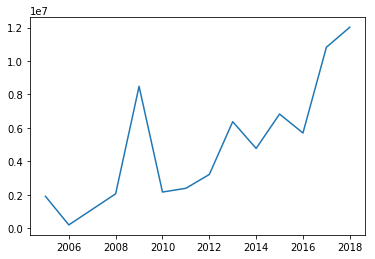

1    오달수
Name: actorNm, dtype: object


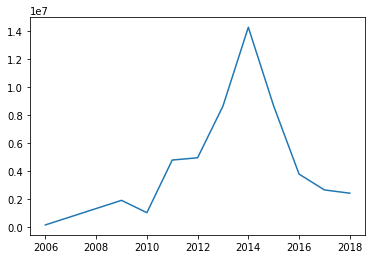

2    황정민
Name: actorNm, dtype: object


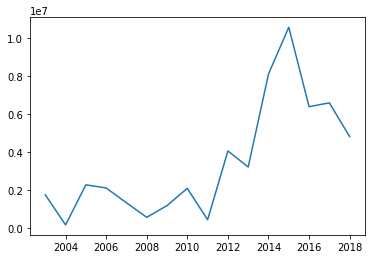

3    송강호
Name: actorNm, dtype: object


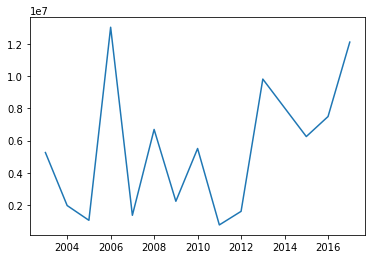

4    유해진
Name: actorNm, dtype: object


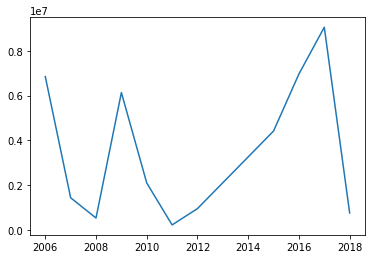

5    류승룡
Name: actorNm, dtype: object


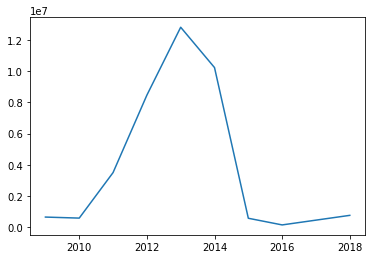

6    설경구
Name: actorNm, dtype: object


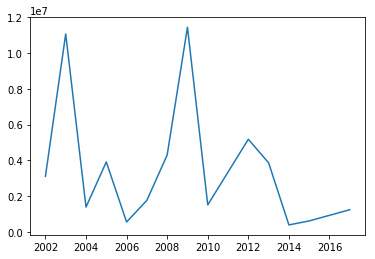

7    김윤석
Name: actorNm, dtype: object


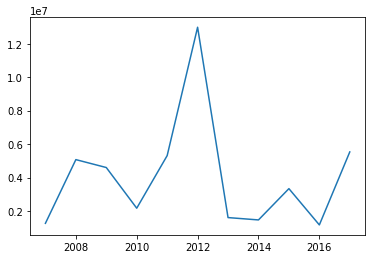

8    로버트 다우니 주니어
Name: actorNm, dtype: object


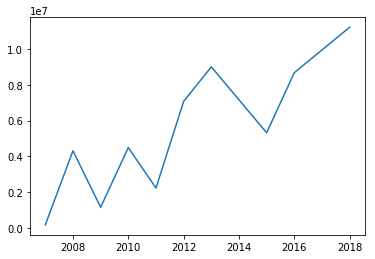

9    이정재
Name: actorNm, dtype: object


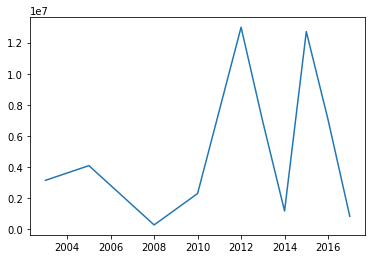

10    이병헌
Name: actorNm, dtype: object


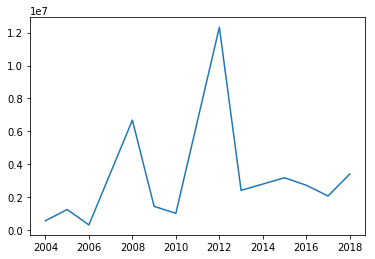

11    마동석
Name: actorNm, dtype: object


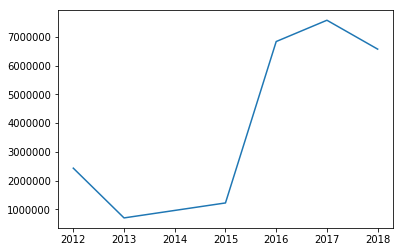

12    스칼렛 요한슨
Name: actorNm, dtype: object


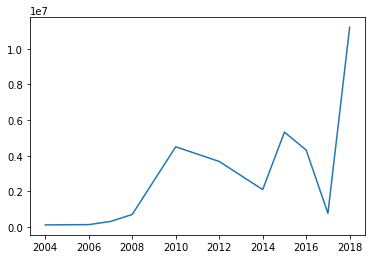

13    강동원
Name: actorNm, dtype: object


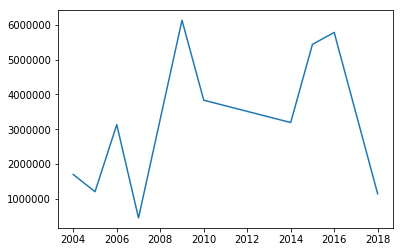

14    조진웅
Name: actorNm, dtype: object


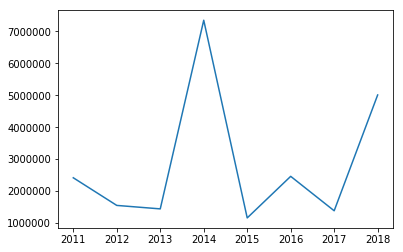

15    크리스 에반스
Name: actorNm, dtype: object


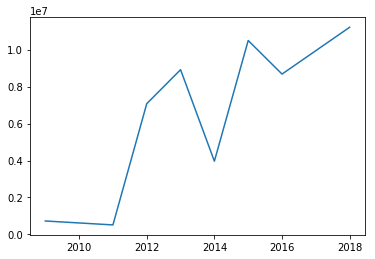

16    정재영
Name: actorNm, dtype: object


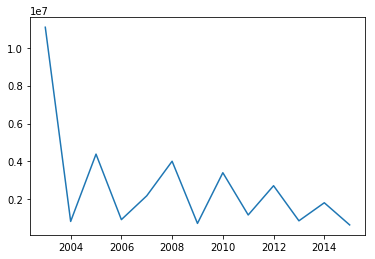

17    정진영
Name: actorNm, dtype: object


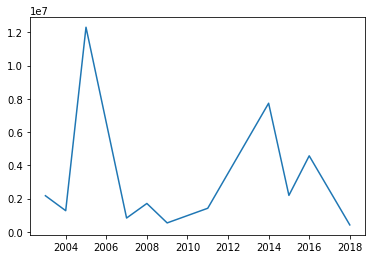

18    톰 크루즈
Name: actorNm, dtype: object


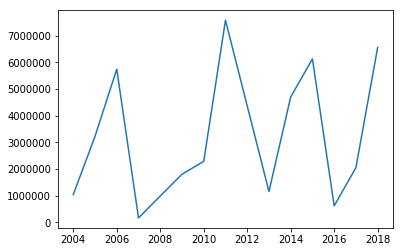

19    최민식
Name: actorNm, dtype: object


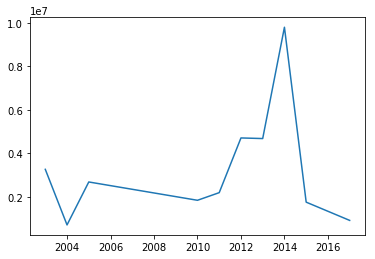

20    박해일
Name: actorNm, dtype: object


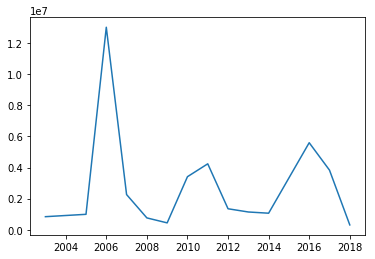

21    크리스 헴스워스
Name: actorNm, dtype: object


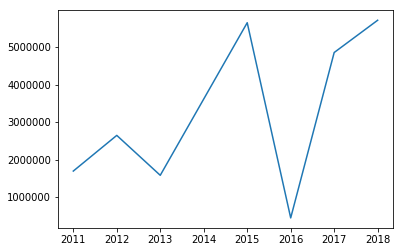

22    차태현
Name: actorNm, dtype: object


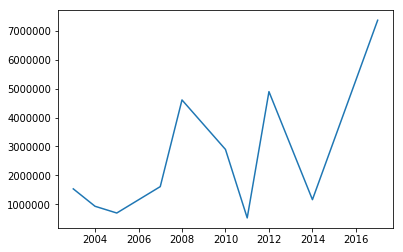

23    김동욱
Name: actorNm, dtype: object


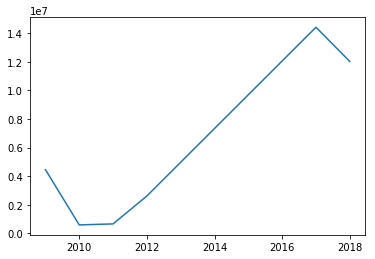

24    손예진
Name: actorNm, dtype: object


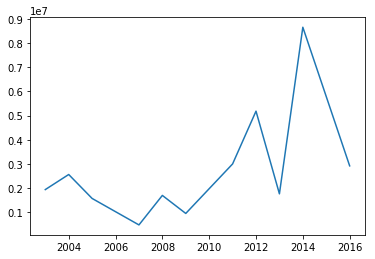

25    주지훈
Name: actorNm, dtype: object


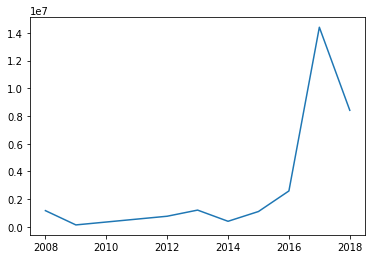

26    정우성
Name: actorNm, dtype: object


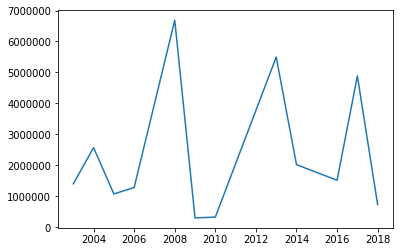

27    김혜수
Name: actorNm, dtype: object


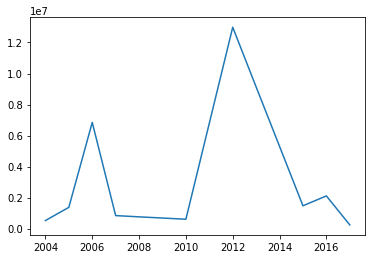

28    안성기
Name: actorNm, dtype: object


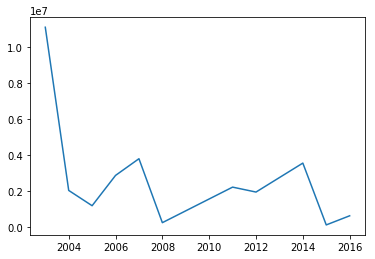

29    마크 러팔로
Name: actorNm, dtype: object


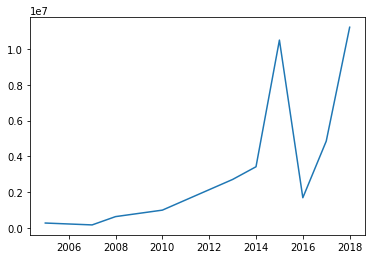

In [224]:
for i in mainActorCd[:30]:
    print(actorMain_total[actorMain_total.actorCd==i].actorNm)
    temp = movie_actor_RoleMain[movie_actor_RoleMain.actorCd==i]
    temp = temp.groupby('openYr').mean()
    plt.plot(temp.index.tolist(), temp.audiAcc.tolist())
    plt.show()

'10087253'

numpy.int64

In [147]:
temp.sort_values(["movieCd"], ascending=False)

,movieNm,movieCd,actorNm,repNationNm,actorCd,actorRole
32837,NaN,20189861,캐리 쿤,NaN,NaN,조연
32839,NaN,20189861,마이클 스털버그,NaN,NaN,조연
32841,NaN,20189861,존 루,NaN,NaN,조연
12833,더 포스트,20189861,브루스 그린우드,미국,10032426,조연
12832,더 포스트,20189861,사라 폴슨,미국,10033980,조연
12831,더 포스트,20189861,알리슨 브리,미국,10046274,조연
32838,NaN,20189861,제시 플레먼스,NaN,NaN,조연
32840,NaN,20189861,팻 힐리,NaN,NaN,조연
12829,더 포스트,20189861,톰 행크스,미국,10081113,주연
32836,NaN,20189861,브래드리 휘트포드,NaN,NaN,조연


이 때, 문제점은 "movieCd와 actorNm이 동일한 것들은 어떻게 반영을 했을 것인가" 에 대한 것이다.

In [160]:
movie_actor[movie_actor.duplicated(subset=['movieCd','actorNm'], keep=False)]

,movieNm,movieCd,actorNm,naverCd
321,변호인,20134803,김서영,101901
325,변호인,20134803,김서영,101901
410,검사외전,20145507,박지환,130903
416,검사외전,20145507,박지환,130903
836,곡성,20140194,배용근,121051
837,곡성,20140194,배용근,121051
1467,군도: 민란의 시대,20123501,이경영,99752
1471,군도: 민란의 시대,20123501,이경영,99752
2105,가문의 부활 - 가문의 영광3,20060257,서명석,57729
2106,가문의 부활 - 가문의 영광3,20060257,서명석,57729


In [155]:
temp[temp.duplicated(subset=['movieCd', 'actorNm'], keep=False)]

,movieNm,movieCd,actorNm,naverCd,actorRole
410,검사외전,20145507,박지환,130903,조연
416,검사외전,20145507,박지환,130903,조연
1467,군도: 민란의 시대,20123501,이경영,99752,조연
1471,군도: 민란의 시대,20123501,이경영,99752,조연
2182,이끼,20100209,유준상,52326,주연
2190,이끼,20100209,유준상,52326,주연
2560,식객,20070435,정진,62167,조연
2561,식객,20070435,정진,62167,조연
2570,식객,20070435,정진,62167,조연
2668,26년,20088506,이경영,47384,조연


In [159]:
#kobis를 통한 movie_actor의 row 갯수
print(len(movie_actor))
#naver를 통해 주조연을 추가해준 것의 row 갯수
print(len(temp))

#movie_actor의 한 영화에 동명이인이 나올 갯수
print(len(movie_actor[movie_actor.duplicated(subset=['movieNm','actorNm'])]))
#주조연정보를 추가했을 때, 한 영화에 동명이인
print(len(temp[temp.duplicated(subset=['movieNm', 'actorNm'])]))

15096
15101
68
73


둘의 차이가 

In [ ]:
#그리고 주조연정보가 없는 배우는 누락시킨다.
#temp = temp.dropna(subset=['actorRole'])

In [58]:
temp = temp.reset_index(drop=True)

In [59]:
movie_actorRole = pd.read_csv("movie_actorRole_utf-8.csv")

,movieCd,actorNm,actorRole
0,20129370,최민식,주연
1,20129370,류승룡,주연
2,20129370,조진웅,주연
3,20129370,진구,조연
4,20129370,이정현,조연
5,20129370,김명곤,조연
6,20129370,권율,조연
7,20129370,노민우,조연
8,20129370,김태훈,조연
9,20129370,오타니 료헤이,조연


In [121]:
temp = temp[temp.actorCd!='00000001']

In [76]:
#이름과 필모, 맡은 역을 잘 보고 넣어주어야한다.
temp.actorCd[424]='10029093'
temp.actorCd[842]='10057329'
temp.actorCd[1765]='20125821'
temp.actorCd[2315]='20133634'
temp.actorCd[2316]='10062270'
temp.actorCd[2855]='10061581'
temp.actorCd[2862]='20110690'
temp.actorCd[3318]='10062279'
temp.actorCd[4981]='20274790'
temp.actorCd[5373]='20133526'
temp.actorCd[5374]='10029413'
temp.actorCd[6496]='20110693'
temp.actorCd[8239]='10058190'
temp.actorCd[8243]='20115001'
temp.actorCd[8366]='20153088'
temp.actorCd[9144]='10071672'
temp.actorCd[9650]='20066512'
temp.actorCd[11975]='20127460'
temp.actorCd[13185]='20145269'

In [69]:
len(temp2[temp2.actorCd=='00000001'])

25

In [84]:
temp2 = pd.merge(temp, movie_actorRole, on=['movieCd', 'actorNm'], how='left')

In [71]:
temp2

,movieNm,movieCd,actorNm,repNationNm,actorCd,actorRole
0,명량,20129370,최민식,한국,10072251,주연
1,명량,20129370,류승룡,한국,10019065,주연
2,명량,20129370,조진웅,한국,10067353,주연
3,명량,20129370,김명곤,한국,10004052,조연
4,명량,20129370,진구,한국,10070417,조연
5,명량,20129370,이정현,한국,10057329,조연
6,명량,20129370,권율,한국,20175963,조연
7,명량,20129370,노민우,한국,20236729,조연
8,명량,20129370,김태훈,한국,10006155,조연
9,명량,20129370,이승준,한국,10056268,조연


In [70]:
print(len(temp))
print(len(temp2))

13739
13744


In [81]:
temp[temp.duplicated(subset=['movieCd', 'actorNm', 'actorCd'], keep=False)]

In [83]:
temp = temp.drop_duplicates(subset=['movieCd', 'actorNm', 'actorCd'])
temp = temp.reset_index(drop=True)

In [86]:
len(temp)

13695

In [87]:
len(temp2)

13700

In [92]:
temp2[temp2.duplicated(subset=['movieCd', 'actorNm', 'actorCd'], keep=False)]

,movieNm,movieCd,actorNm,repNationNm,actorCd,actorRole


In [91]:
temp2 = temp2.drop(2847)
temp2 = temp2.drop(2854)
temp2 = temp2.drop(4444)
temp2 = temp2.drop(12026)
temp2 = temp2.drop(13297)

In [95]:
temp2.dropna(subset=['actorRole'])

In [100]:
temp2.to_csv("temp2.csv", index=False)

In [98]:
temp3 = temp3[temp3.actorRole=="주연"]

,movieNm,movieCd,actorNm,repNationNm,actorCd,actorRole
0,명량,20129370,최민식,한국,10072251,주연
1,명량,20129370,류승룡,한국,10019065,주연
2,명량,20129370,조진웅,한국,10067353,주연
25,신과함께-죄와 벌,20150976,하정우,한국,10087253,주연
26,신과함께-죄와 벌,20150976,차태현,한국,10071209,주연
27,신과함께-죄와 벌,20150976,주지훈,한국,10069179,주연
28,신과함께-죄와 벌,20150976,김향기,한국,10006228,주연
29,신과함께-죄와 벌,20150976,마동석,한국,10021341,주연
30,신과함께-죄와 벌,20150976,김동욱,한국,10003967,주연
47,국제시장,20137048,황정민,한국,10090290,주연


In [198]:
movie_total[(movie_total.openYr>2014)&(movie_total.openYr<2018)].to_csv("train.csv", index=False, encoding='utf-8')

In [199]:
movie_total[(movie_total.openYr>2017)&(movie_total.openMth<7)].to_csv("test.csv", index=False, encoding='utf-8')

# movie_total, movie_actor 등 가져오기

In [8]:
movie_total = pd.read_csv("movie_total.csv")

In [200]:
movieInfo = movie_total[["movieCd", "movieNm","openYr", "openMth"]]

In [23]:
movie_actor = pd.merge(movie_actor_Role, movieInfo, on="movieCd", how="left")

In [48]:
movie_mainAct = movie_actor[movie_actor.actorRole=="주연"].reset_index(drop=True)
#actorNm = movie_mainAct[["actorNm", "actorCd"]].drop_duplicates()

### 여기부터 작업시작

In [187]:
#2014년까지의 factor
temp = movie_mainAct[(movie_mainAct.openYr<=2017)
                     |((movie_mainAct.openYr==2018)&(movie_mainAct.openMth<=6))]
temp = temp.groupby("actorCd").mean().reset_index(drop=False)
temp = temp[["actorCd", "audiAcc"]]
temp.columns = ["actorCd", "2018_2mean"]
temp

,actorCd,2018_2mean
0,10000109,1.771450e+05
1,10000110,1.111158e+06
2,10000212,2.684740e+05
3,10000222,1.404557e+06
4,10000337,2.141357e+06
5,10000377,1.174010e+05
6,10000433,2.069567e+06
7,10000451,4.369030e+05
8,10000461,2.848548e+06
9,10000558,3.504103e+06


In [188]:
imsi = pd.merge(imsi, temp, on="actorCd", how="left")

,movieNm,movieCd,actorNm,repNationNm,actorCd,actorEnNm,actorRole,openYr,openMth,audiAcc,...,2016_1mean,2016_2mean,2016_3mean,2016_4mean,2017_1mean,2017_2mean,2017_3mean,2017_4mean,2018_1mean,2018_2mean
0,명량,20129370,최민식,한국,10072251,CHOI Min-shik,주연,2014,7,17613682,...,4.013979e+06,4.013979e+06,4.013979e+06,4.013979e+06,4.013979e+06,3.793034e+06,3.793034e+06,3.538792e+06,3.538792e+06,3.538792e+06
1,명량,20129370,류승룡,한국,10019065,RYU Seung-ryong,주연,2014,7,17613682,...,4.800400e+06,4.800400e+06,4.490143e+06,4.490143e+06,4.490143e+06,4.490143e+06,4.490143e+06,4.490143e+06,4.051192e+06,4.051192e+06
2,명량,20129370,조진웅,한국,10067353,CHO Jin-woong,주연,2014,7,17613682,...,3.391117e+06,3.236180e+06,3.236180e+06,3.236180e+06,3.079672e+06,3.043374e+06,3.043374e+06,2.865854e+06,2.865854e+06,3.011829e+06
3,명량,20129370,김명곤,한국,10004052,KIM Myung-kon,조연,2014,7,17613682,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,명량,20129370,진구,한국,10070417,JIN Goo,조연,2014,7,17613682,...,1.833238e+06,1.833238e+06,1.833238e+06,1.833238e+06,1.658312e+06,1.658312e+06,1.658312e+06,1.658312e+06,1.658312e+06,1.658312e+06
5,명량,20129370,이정현,한국,10057329,LEE Jung-hyun,조연,2014,7,17613682,...,NaN,NaN,NaN,7.574300e+05,7.574300e+05,7.574300e+05,3.674790e+06,3.674790e+06,3.674790e+06,3.674790e+06
6,명량,20129370,권율,한국,20175963,KWON Yul,조연,2014,7,17613682,...,NaN,6.459220e+05,3.986410e+05,3.986410e+05,3.986410e+05,3.986410e+05,3.986410e+05,3.986410e+05,3.986410e+05,6.408703e+05
7,명량,20129370,노민우,한국,20236729,NO Min-woo,조연,2014,7,17613682,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,명량,20129370,김태훈,한국,10006155,KIM Tae-hun,조연,2014,7,17613682,...,2.248910e+05,2.248910e+05,2.248910e+05,2.248910e+05,2.248910e+05,2.248910e+05,2.248910e+05,2.248910e+05,2.248910e+05,2.248910e+05
9,명량,20129370,이승준,한국,10056268,LEE Seung-jun,조연,2014,7,17613682,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [247]:
imsi[imsi.movieCd=="20170669"]

,movieNm,movieCd,actorNm,repNationNm,actorCd,actorEnNm,actorRole,openYr,openMth,audiAcc,...,2016_1mean,2016_2mean,2016_3mean,2016_4mean,2017_1mean,2017_2mean,2017_3mean,2017_4mean,2018_1mean,2018_2mean


In [189]:
imsi.to_csv("movie_actor_power.csv", index=False)

In [227]:
imsi_sum = imsi[((imsi.openYr>=2015)&(imsi.openYr<=2017))|((imsi.openYr==2018)&(imsi.openMth<=6))].groupby("movieCd").sum().reset_index(drop=False)

In [229]:
del imsi_sum["openYr"]
del imsi_sum["openMth"]

In [230]:
movieInfo

,movieCd,movieNm,openYr,openMth
0,20129370,명량,2014,7
1,20150976,신과함께-죄와 벌,2017,12
2,20137048,국제시장,2014,12
3,20090834,아바타,2009,12
4,20148048,베테랑,2015,8
5,20060151,괴물,2006,7
6,20124034,도둑들,2012,7
7,20127593,7번방의 선물,2013,1
8,20148851,암살,2015,7
9,20124079,"광해, 왕이 된 남자",2012,9


In [231]:
imsi_sum = pd.merge(imsi_sum, movieInfo, on="movieCd", how="left")

In [206]:
imsi_sum.columns

Index(['movieCd', 'audiAcc', '2014sum', '2015_1sum', '2015_2sum', '2015_3sum',
       '2015_4sum', '2016_1sum', '2016_2sum', '2016_3sum', '2016_4sum',
       '2017_1sum', '2017_2sum', '2017_3sum', '2017_4sum', '2018_1sum',
       '2018_2sum', '2014mean', '2015_1mean', '2015_2mean', '2015_3mean',
       '2015_4mean', '2016_1mean', '2016_2mean', '2016_3mean', '2016_4mean',
       '2017_1mean', '2017_2mean', '2017_3mean', '2017_4mean', '2018_1mean',
       '2018_2mean', 'movieNm', 'openYr', 'openMth'],
      dtype='object')

In [233]:
imsi_sum = pd.DataFrame(imsi_sum, columns=['movieNm', 'movieCd', 'openYr', 'openMth', 'audiAcc', '2014sum', '2015_1sum', '2015_2sum', '2015_3sum',
       '2015_4sum', '2016_1sum', '2016_2sum', '2016_3sum', '2016_4sum',
       '2017_1sum', '2017_2sum', '2017_3sum', '2017_4sum', '2018_1sum',
       '2018_2sum', '2014mean', '2015_1mean', '2015_2mean', '2015_3mean',
       '2015_4mean', '2016_1mean', '2016_2mean', '2016_3mean', '2016_4mean',
       '2017_1mean', '2017_2mean', '2017_3mean', '2017_4mean', '2018_1mean',
       '2018_2mean'])

In [234]:
actorPowersum = []
actorPowermean = []

openYr = imsi_sum.openYr
openMth = imsi_sum.openMth
sum2014 = imsi_sum["2014sum"]
sum2015_1 = imsi_sum["2015_1sum"]
sum2015_2 = imsi_sum["2015_2sum"]
sum2015_3 = imsi_sum["2015_3sum"]
sum2015_4 = imsi_sum["2015_4sum"]
sum2016_1 = imsi_sum["2016_1sum"]
sum2016_2 = imsi_sum["2016_2sum"]
sum2016_3 = imsi_sum["2016_3sum"]
sum2016_4 = imsi_sum["2016_4sum"]
sum2017_1 = imsi_sum["2017_1sum"]
sum2017_2 = imsi_sum["2017_2sum"]
sum2017_3 = imsi_sum["2017_3sum"]
sum2017_4 = imsi_sum["2017_4sum"]
sum2018_1 = imsi_sum["2018_1sum"]
sum2018_2 = imsi_sum["2018_2sum"]

mean2014 = imsi_sum["2014mean"]
mean2015_1 = imsi_sum["2015_1mean"]
mean2015_2 = imsi_sum["2015_2mean"]
mean2015_3 = imsi_sum["2015_3mean"]
mean2015_4 = imsi_sum["2015_4mean"]
mean2016_1 = imsi_sum["2016_1mean"]
mean2016_2 = imsi_sum["2016_2mean"]
mean2016_3 = imsi_sum["2016_3mean"]
mean2016_4 = imsi_sum["2016_4mean"]
mean2017_1 = imsi_sum["2017_1mean"]
mean2017_2 = imsi_sum["2017_2mean"]
mean2017_3 = imsi_sum["2017_3mean"]
mean2017_4 = imsi_sum["2017_4mean"]
mean2018_1 = imsi_sum["2018_1mean"]
mean2018_2 = imsi_sum["2018_2mean"]

In [235]:
for i in imsi_sum.index.tolist():
    if (openYr[i]==2015)&(openMth[i]<=3):
        actorPowersum.append(sum2014[i])
        actorPowermean.append(mean2014[i])
        
    elif (openYr[i]==2015)&(openMth[i]<=6):
        actorPowersum.append(sum2015_1[i])
        actorPowermean.append(mean2015_1[i])
        
    elif (openYr[i]==2015)&(openMth[i]<=9):
        actorPowersum.append(sum2015_2[i])
        actorPowermean.append(mean2015_2[i])
        
    elif (openYr[i]==2015)&(openMth[i]<=12):
        actorPowersum.append(sum2015_3[i])
        actorPowermean.append(mean2015_3[i])
        
    elif (openYr[i]==2016)&(openMth[i]<=3):
        actorPowersum.append(sum2015_4[i])
        actorPowermean.append(mean2015_4[i])
        
    elif (openYr[i]==2016)&(openMth[i]<=6):
        actorPowersum.append(sum2016_1[i])
        actorPowermean.append(mean2016_1[i])
        
    elif (openYr[i]==2016)&(openMth[i]<=9):
        actorPowersum.append(sum2016_2[i])
        actorPowermean.append(mean2016_2[i])
        
    elif (openYr[i]==2016)&(openMth[i]<=12):
        actorPowersum.append(sum2016_3[i])
        actorPowermean.append(mean2016_3[i])
        
    elif (openYr[i]==2017)&(openMth[i]<=3):
        actorPowersum.append(sum2016_4[i])
        actorPowermean.append(mean2016_4[i])
        
    elif (openYr[i]==2017)&(openMth[i]<=6):
        actorPowersum.append(sum2017_1[i])
        actorPowermean.append(mean2017_1[i])
        
    elif (openYr[i]==2017)&(openMth[i]<=9):
        actorPowersum.append(sum2017_2[i])
        actorPowermean.append(mean2017_2[i])
        
    elif (openYr[i]==2017)&(openMth[i]<=12):
        actorPowersum.append(sum2017_3[i])
        actorPowermean.append(mean2017_3[i])
        
    elif (openYr[i]==2018)&(openMth[i]<=3):
        actorPowersum.append(sum2017_4[i])
        actorPowermean.append(mean2017_4[i])
        
    elif (openYr[i]==2018)&(openMth[i]<=6):
        actorPowersum.append(sum2018_1[i])
        actorPowermean.append(mean2018_1[i])

In [236]:
imsi_sum['actorPowersum']=pd.Series(actorPowersum)
imsi_sum['actorPowermean']=pd.Series(actorPowermean)

In [238]:
imsi_sum.to_csv("imsi_actorPower.csv", index=False)

In [240]:
imsi_sum[imsi_sum.actorPowersum.isnull()]

,movieNm,movieCd,openYr,openMth,audiAcc,2014sum,2015_1sum,2015_2sum,2015_3sum,2015_4sum,...,2016_3mean,2016_4mean,2017_1mean,2017_2mean,2017_3mean,2017_4mean,2018_1mean,2018_2mean,actorPowersum,actorPowermean


In [245]:
imsi_sum[imsi_sum.movieCd=="20170669"]

,movieNm,movieCd,openYr,openMth,audiAcc,2014sum,2015_1sum,2015_2sum,2015_3sum,2015_4sum,...,2016_3mean,2016_4mean,2017_1mean,2017_2mean,2017_3mean,2017_4mean,2018_1mean,2018_2mean,actorPowersum,actorPowermean
